In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lib.fl_model_v10 import *
import pygmo as pg
import statsmodels.api as sm

C:\Users\timro\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#  Code

In [2]:
case = "Nepal"
output_folder = "Simulation-results"

In [3]:
# Load data (deserialize)
with open('{}/{}/python_objects.pickle'.format(case, output_folder),
          'rb') as handle:
    global_label_tree, EMA_model_dict, global_dfs_var_unc_data, global_fixed_unc, global_policy_tree = pickle.load(
        handle)

In [4]:
# For period x, get all resulting policies

In [5]:
def find_nodes_next_step(node,label_tree):
    # Find which period
    for i,l in enumerate(reversed(node)):
        if l == 'p':
            period = int((list(reversed(node))[i-1]))
            break
    # Find next period
    labels_next_p = label_tree["p{}".format(period+1)]
#     print(labels_next_p)
    return [l for l in labels_next_p if node in l]

find_nodes_next_step('p0n0p1n2', global_label_tree)

['p0n0p1n2p2n15', 'p0n0p1n2p2n16', 'p0n0p1n2p2n17', 'p0n0p1n2p2n18']

In [6]:
def get_mordm_resulting_policies(node, label_tree, policy_tree):
    # Get all labels of resulting mordm cycle
    labels = find_nodes_next_step(node,label_tree)
    # Get all policies for these labels
    policies = [policy_tree[label] for label in labels] 
    return policies

# get_mordm_resulting_policies("p0n0", global_label_tree, global_policy_tree)

In [7]:
def get_all_mordms_in_period(period, label_tree, policy_tree):
    nodes = label_tree[period]
    mordm_results = [get_mordm_resulting_policies(node,label_tree,policy_tree) for node in nodes]
    return mordm_results

# get_all_mordms_in_period("p1",global_label_tree,global_policy_tree)

In [8]:
p1_mordm_pol_sets = get_all_mordms_in_period("p1", global_label_tree,
                                             global_policy_tree)

In [9]:
# For all policies, evaluate on real values

In [10]:
DPs = pd.read_csv("Nepal/Prepared Input Data/DPs.csv")
# DPs.columns

FLs = pd.read_csv("Nepal/Prepared Input Data/FLs.csv")
# FLs.columns

SPs = pd.read_csv("Nepal/Prepared Input Data/SPs.csv")
# SPs.columns
Fix_Unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case), index_col=0)
# Fix_Unc

In [11]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}
# DPpop = {"DPpop{}".format(i): random.uniform(10,100) for i in range(nr_of_DPs)}

In [12]:
epicentre_name = "RealLocation"
disruptionsFLs = np.loadtxt(
    '{}/Prepared Input Data/DisruptionFL{}.txt'.format(case,epicentre_name))
disruptionsDPs = np.loadtxt(
    '{}/Prepared Input Data/DisruptionDP{}.txt'.format(case,epicentre_name))

# DSRDP = {"DSRDP{}".format(i): 1.5 for i in range(len(DPX))}
# DSRFL = {"DSRFL{}".format(i): 1.5 for i in range(len(FLX))}

In [13]:
DSRDP = {"DSRDP{}".format(i): disruptionsDPs[i] for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): disruptionsFLs[i] for i in range(len(FLX))}

In [14]:
def evaluate_pol_set(pol_set):
    results = []
    for policy in pol_set:
        results.append(FL_model(
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))
    return results

In [15]:
def get_branch_performance(period, label_tree, policy_tree):
    p_mordm_pol_sets = get_all_mordms_in_period(period, label_tree,
                                                policy_tree)
    result_sets = []
    for pol_set in p_mordm_pol_sets:
        result_sets.append(evaluate_pol_set(pol_set))
    return result_sets

In [16]:
sets = get_branch_performance('p1',global_label_tree,global_policy_tree)

In [17]:
# For each mordm cycle, calculate hypervolume

In [18]:
# normalise_df(df)

In [19]:
def normalise_df (df):
    normalised_df=(df-df.min())/(df.max()-df.min())
    return normalised_df

In [20]:
def normalise_sets(all_sets):
    """
    unity-based normalisation for normalisation between 0 and 1
    All sets are first merged, then normalised, then split again.
    This way the normalisation is over the full span of values in all sets
    """
    df = pd.DataFrame()
    for i, s in enumerate(all_sets):
        dftemp = pd.DataFrame(s)
        dftemp['set'] = i
        df = df.append(dftemp)
    df = df.reset_index(drop=True)
    df_normalised = normalise_df(df.iloc[:, :4])
    df_normalised['set'] = df['set']

    sets_normalised = []
    for i in sorted(list(set(df_normalised.set))):
        sets_normalised.append(df_normalised[df_normalised.set == i].values)
    return sets_normalised

In [22]:
# sets_normalised

In [23]:
def compute_hypervolumes(normalised_sets):
    ref_point = [1,1,1,1]
    hvs = []
    for tmpset in normalised_sets:
        hv = pg.hypervolume(tmpset.astype(float)[:,:4])
        hvs.append(hv.compute(ref_point))
    return hvs

In [24]:
# For each mordm cycle, calculate uncertainty space.

In [25]:
def get_uncertainty_bandwiths(period,
                              label_tree,
                              var_unc_data,
                              function="mean"):
    """
    period: string: E.g. "p0"
    function: string. function to perform on pandas Series.
        E.g.: mean, max, min
    """
    p_labels = label_tree[period]
    bandwidth_metrics = []
    for l in p_labels:
        bandwith = (var_unc_data[l].upper - var_unc_data[l].lower)
        metric = eval("bandwith.{}()".format(function))
#         print(l)
#         print(bandwith)
        bandwidth_metrics.append(metric)
    return bandwidth_metrics

In [26]:
sets = get_branch_performance('p3', global_label_tree,
                              global_policy_tree)

sets_normalised = normalise_sets(sets)

hvs = compute_hypervolumes(sets_normalised)

In [27]:
len(hvs)

231

In [28]:
bws = get_uncertainty_bandwiths('p3', global_label_tree,
                                global_dfs_var_unc_data)

In [31]:
lengths = []
for i,p3label in enumerate(global_label_tree['p3']):
    count = 0
    for label in global_label_tree['p4']:
        if p3label in label:
            count += 1
            
    lengths.append(count)
#             print(label)

In [32]:
len(lengths)

231

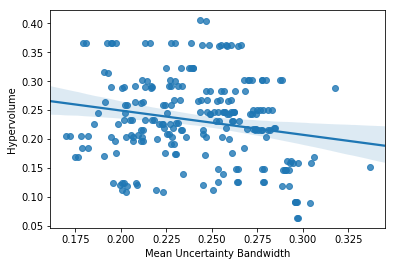

In [62]:
data = pd.DataFrame([hvs, bws]).T
data.columns = ['hvs', 'unc_bws']
import seaborn as sns

ax = sns.regplot(y='hvs', x='unc_bws', data=data)
ax.set(
    xlabel='Mean Uncertainty Bandwidth',
    ylabel="Hypervolume",
#     title="Pareto Front Estimation Performance for Uncertainty Bandwidths\nScatter with Regression Line"
)
plt.savefig("{}/Analysis/HVxUNC_no_correction".format(case), dpi=500)
# plt.show()

In [50]:
hv_perelement = np.array(hvs) / np.array(lengths)

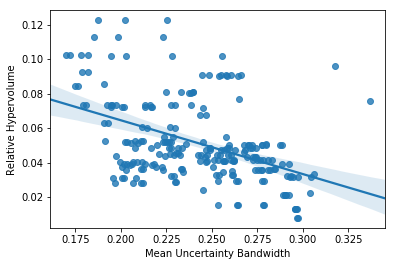

In [63]:
data = pd.DataFrame([hv_perelement, bws]).T
data.columns = ['hvs', 'unc_bws']
import seaborn as sns

ax = sns.regplot(y='hvs', x='unc_bws', data=data)
ax.set(
    xlabel='Mean Uncertainty Bandwidth',
    ylabel="Relative Hypervolume",
#     title="Pareto Front Estimation Performance for Uncertainty Bandwidths\nScatter with Regression Line"
)
plt.savefig("{}/Analysis/HVxUNC_length_correction".format(case), dpi=500)
# plt.show()

In [40]:
def normalise_df2(df):
    normalised_df = (df - 0) / (df.max() - 0)
    return normalised_df

In [53]:
def normalise_df (df):
    normalised_df=(df-df.min())/(df.max()-df.min())
    return normalised_df

In [57]:
X = data['unc_bws']
Y = normalise_df2(data['hvs'])
X = sm.add_constant(X)
mod = sm.OLS(Y,X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    hvs   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     57.78
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           7.49e-13
Time:                        17:31:46   Log-Likelihood:                 77.982
No. Observations:                 231   AIC:                            -152.0
Df Residuals:                     229   BIC:                            -145.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0362      0.082     12.667      0.000       0.875       1.197
unc_bws       -2.5466      0.335     -7.601      0.000      -3.207      -1.886
==============================================================================
Omnibus:                       30.677   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.565
Skew:                           0.935   Prob(JB):                     4.22e-09
Kurtosis:                       3.714   Cond. No.                         31.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
X = data['unc_bws']
Y = normalise_df2(data['hvs'])
X = sm.add_constant(X)
mod = sm.OLS(Y,X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    hvs   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     57.78
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           7.49e-13
Time:                        15:03:31   Log-Likelihood:                 77.982
No. Observations:                 231   AIC:                            -152.0
Df Residuals:                     229   BIC:                            -145.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0362      0.082     12.667      0.000       0.875       1.197
unc_bws       -2.5466      0.335     -7.601      0.000      -3.207      -1.886
==============================================================================
Omnibus:                       30.677   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.565
Skew:                           0.935   Prob(JB):                     4.22e-09
Kurtosis:                       3.714   Cond. No.                         31.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
(res.rsquared)**0.5

0.4488559471136231